In [1]:
import os, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

# custom
PROJECT_PATH = '/n/groups/marks/databases/ukbiobank/users/ralphest/mit6.8610-project'
sys.path.insert(1, PROJECT_PATH)

from utils import (
    data_utils
)

import logits2scores


In [2]:
gene_list = data_utils.read_gene_list('../gene_list.txt')
models = ['esm2s', 'esm2m', 'esm2l', 'esm1v']
model_names = ['ESM2-small', 'ESM2-medium', 'ESM2-large', 'ESM1v']

In [4]:
scores = {g:{m:None for m in models} for g in gene_list}

for gene in gene_list[:]:
    tokens = np.load(f'../data/data/{gene}/esm2s_tokens.npy')
    indicators = np.load(f'../data/data/{gene}/hap_indicator.npy')
    for esm_model in models:
        logits = np.load(f"../data/data/{gene}/{esm_model}_logits.npy")
        model_scores = logits2scores.unsupervised_score(logits=torch.from_numpy(logits).float(),
                                         mutation_indicators=torch.from_numpy(indicators).long(), 
                                         tokens=torch.from_numpy(tokens).long())
        scores[gene][esm_model] = model_scores
        np.save(f"../data/data/{gene}/{esm_model}_scores.npy", model_scores)

In [5]:
all_scores = {m:[] for m in models}

for esm_model in models:
    model_scores = []
    for gene in gene_list:
        model_scores.append(scores[gene][esm_model])
    all_scores[esm_model] = torch.concat(model_scores, dim=0)

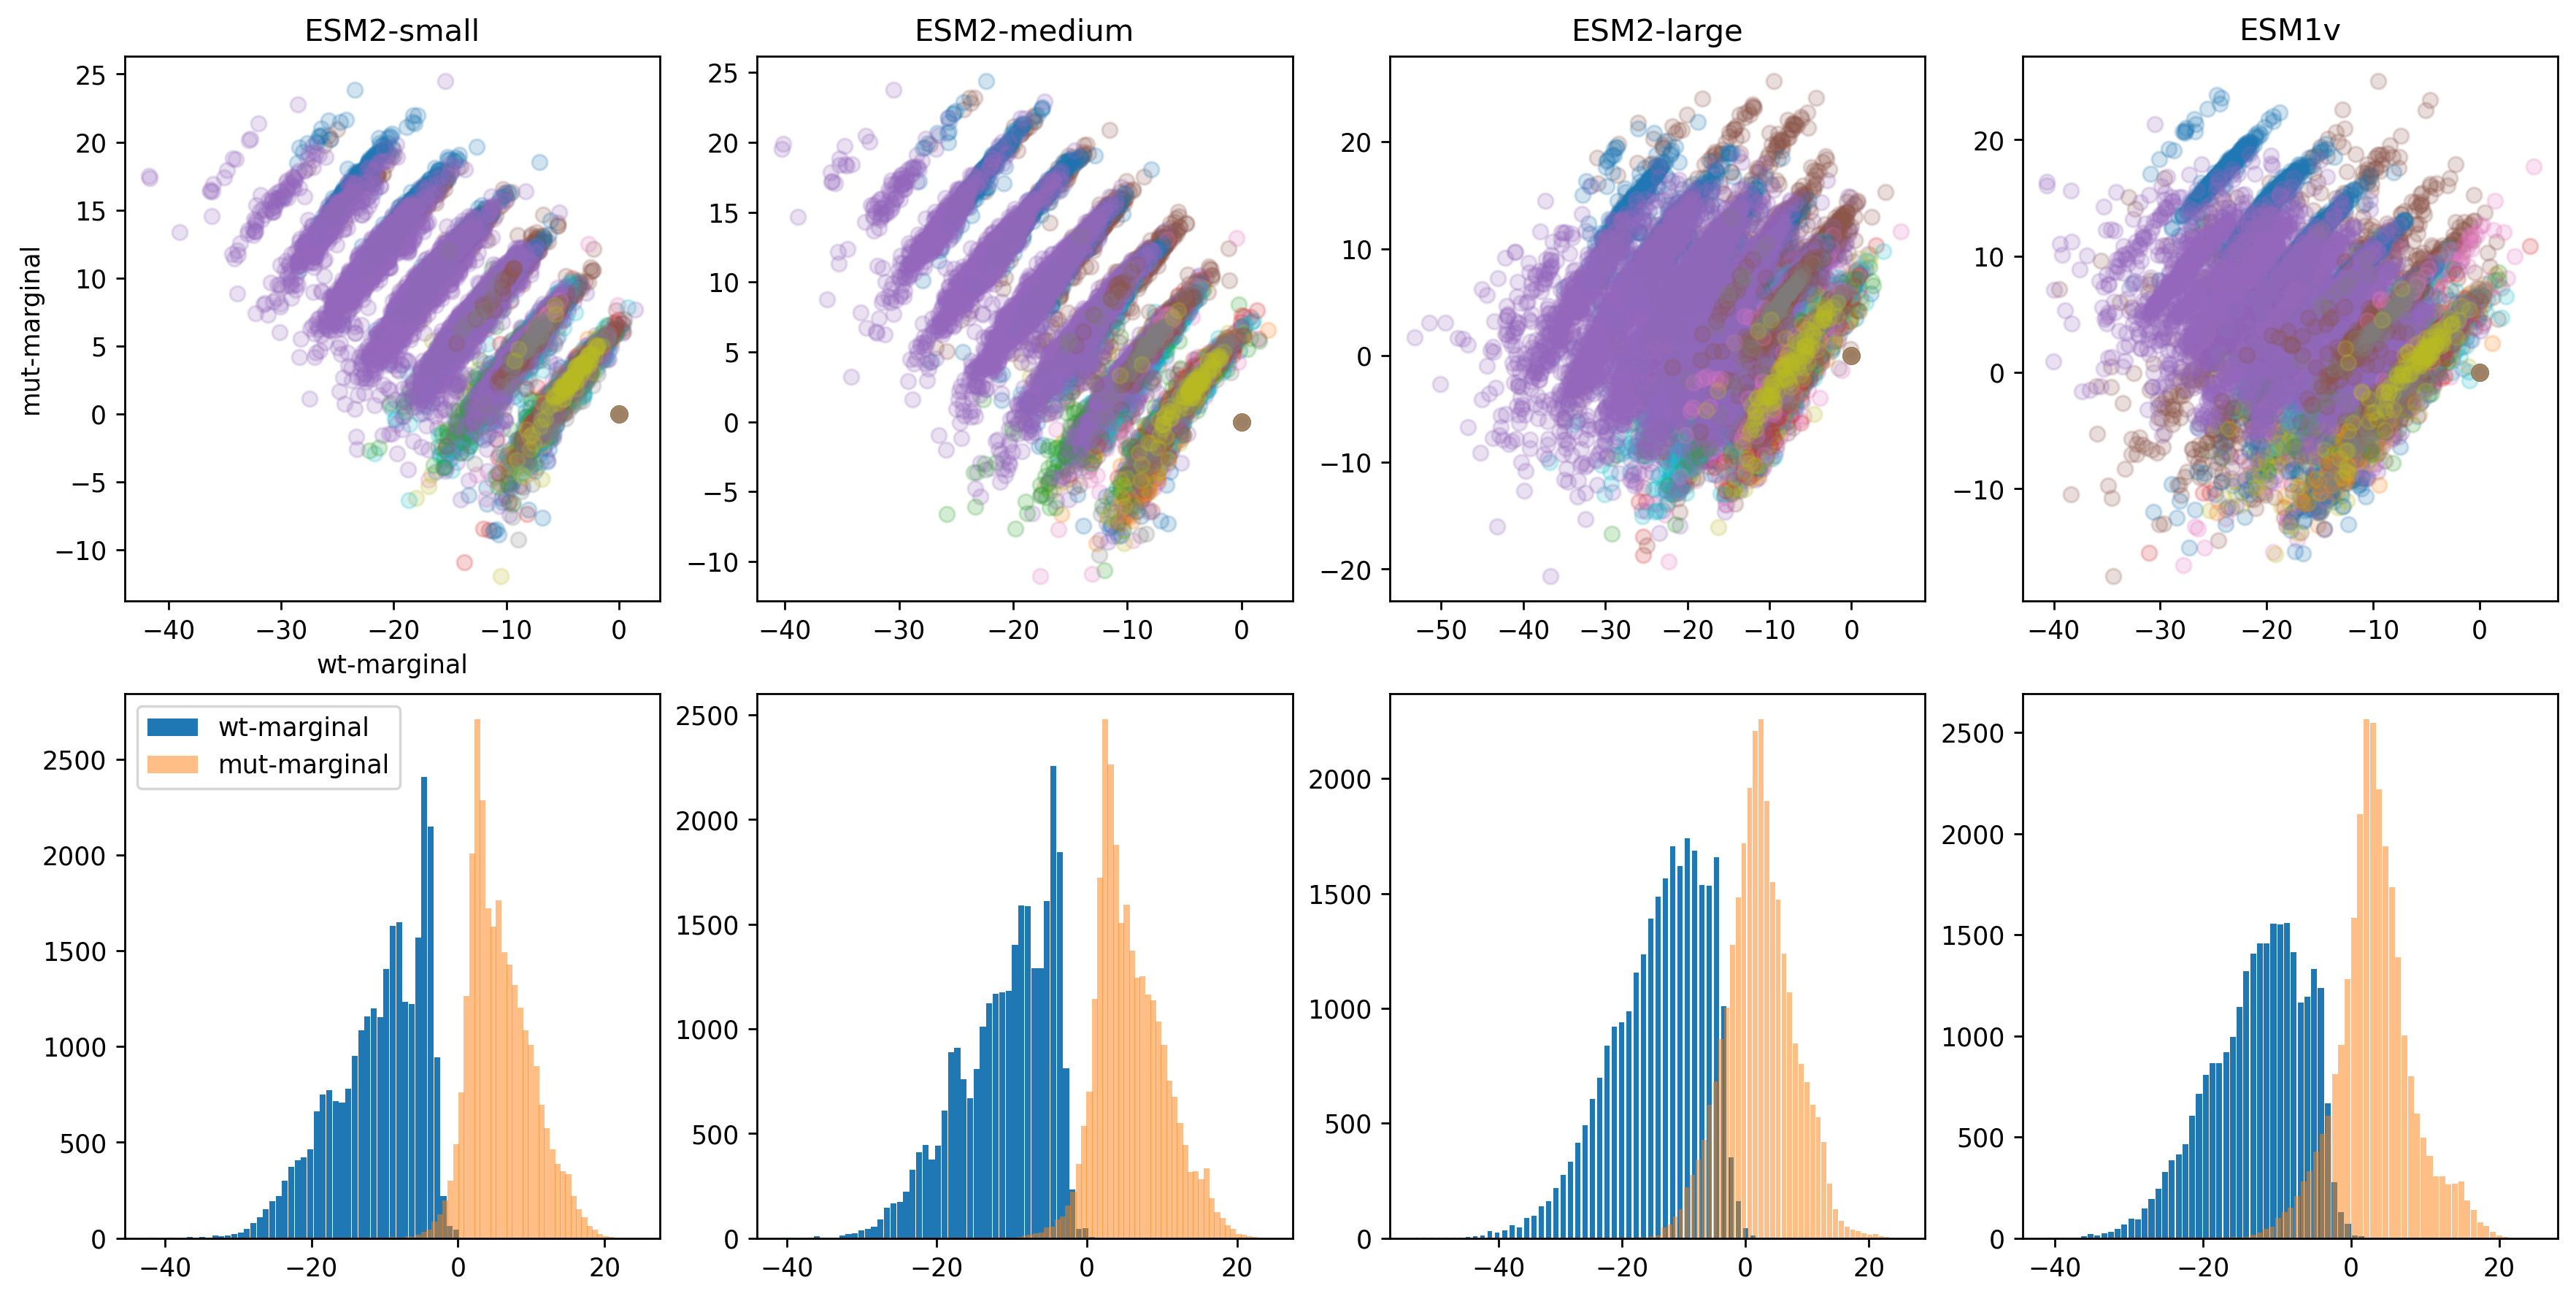

In [6]:
fig, axes = plt.subplots(2,4,figsize=(14,7), constrained_layout=True)

for ax,esm_model,title in zip(axes[0],models, model_names):
    for gene in gene_list:
        ax.scatter(scores[gene][esm_model][:, 0], 
                   scores[gene][esm_model][:, 1], alpha = 0.2)
        ax.set_title(title)
axes[0,0].set_xlabel("wt-marginal")
axes[0,0].set_ylabel("mut-marginal");

for ax,esm_model,title in zip(axes[1],models, model_names):
    heights, bins = np.histogram(all_scores[esm_model][:, 0].flatten(), bins = 50)
    ax.bar(bins[:-1], heights)
    heights, bins = np.histogram(all_scores[esm_model][:, 1].flatten(), bins = 50)
    ax.bar(bins[:-1], heights, alpha=0.5)
axes[1,0].legend(['wt-marginal', 'mut-marginal'])

fig.savefig('../figures/scores_comparison.svg')

In [50]:
for gene in gene_list:
    esm_scores = []
    for esm_model in models:
        esm_scores.append(np.load(f"../data/data/{gene}/{esm_model}_scores.npy"))
    esm_scores = np.concatenate(esm_scores, axis=1)
    np.save(f"../data/data/{gene}/combined_esm_scores.npy", esm_scores)